# 03. Minimal Next-Day Backtest Tutorial

> ⚠️ **Research only. Not financial advice.**

This notebook builds a minimal but correct backtest for **next-day returns** while avoiding look-ahead bias.
We compare two strategy variants:

1. **Variant A**: EMA crossover only
2. **Variant B**: EMA crossover + ATR active-regime filter (current project rule)

## 1) Backtest framing (math + timeline)

We define a daily timeline carefully to avoid leakage.

- At day $t$ close, we can compute indicators and decide a signal.
- That signal becomes a position for day $t+1$.
- Realized return for day $t+1$ is close-to-close:

$$
r_{t+1} = \frac{C_{t+1}}{C_t} - 1
$$

If position decided at day $t$ is $p_t \in \{-1, 0, +1\}$, strategy return at day $t+1$ is:

$$
R^{\text{strat}}_{t+1} = p_t \cdot r_{t+1}
$$

In pandas terms, if `daily_return = close.pct_change()`, then:

$$
\text{strat\_ret}_t = \text{position}_{t-1} \times \text{daily\_return}_t
$$

This is implemented as `position.shift(1) * daily_return`.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make project src importable whether notebook is run from repo root or notebooks/.
repo_root = Path.cwd()
if not (repo_root / "src").exists():
    repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root / "src"))

from quantlab.data import fetch_ohlc
from quantlab.indicators import ema, atr

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', 20)


## 2) Load data (SYMBOL + period knobs)

In [2]:
# You can tweak these knobs and re-run.
SYMBOL = "SPY"
PERIOD = "5y"   # e.g., "2y", "5y", "10y"
INTERVAL = "1d"

# Existing project helper (uses yfinance under the hood).
# If network/data provider is unavailable, we fall back to synthetic OHLC data
# so the tutorial still runs end-to-end in restricted environments.
try:
    price = fetch_ohlc(SYMBOL, period=PERIOD, interval=INTERVAL)
    price = price[["Open", "High", "Low", "Close", "Volume"]].dropna().copy()
    print(f"Loaded market data: {len(price)} rows for {SYMBOL} ({price.index.min().date()} -> {price.index.max().date()})")
except Exception as e:
    print(f"Data fetch failed ({e}). Using synthetic data fallback for tutorial execution.")
    n = 252 * 5
    idx = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    rng = np.random.default_rng(7)
    daily = rng.normal(loc=0.0003, scale=0.012, size=n)
    close = 100 * (1 + pd.Series(daily, index=idx)).cumprod()
    high = close * (1 + rng.uniform(0.0005, 0.01, size=n))
    low = close * (1 - rng.uniform(0.0005, 0.01, size=n))
    open_ = close.shift(1).fillna(close.iloc[0])
    volume = pd.Series(rng.integers(5_000_000, 15_000_000, size=n), index=idx)

    price = pd.DataFrame(
        {
            "Open": open_.values,
            "High": np.maximum(high.values, np.maximum(open_.values, close.values)),
            "Low": np.minimum(low.values, np.minimum(open_.values, close.values)),
            "Close": close.values,
            "Volume": volume.values,
        },
        index=idx,
    )

print(f"Dataset in use: {len(price)} rows ({price.index.min().date()} -> {price.index.max().date()})")
price.head(3)


Failed to get ticker 'SPY' reason: Failed to perform, curl: (56) CONNECT tunnel failed, response 403. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.



1 Failed download:


['SPY']: ProxyError('Failed to perform, curl: (56) CONNECT tunnel failed, response 403. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Data fetch failed (Failed to fetch data for SPY). Using synthetic data fallback for tutorial execution.
Dataset in use: 1260 rows (2021-04-15 -> 2026-02-11)


,Open,High,Low,Close,Volume
2021-04-15,100.031476,100.938938,99.910824,100.031476,12035484
2021-04-16,100.031476,100.812940,100.031476,100.420093,8612363
2021-04-19,100.420093,100.697543,99.576006,100.119872,6479911


## 3) Compute signals for two variants

In [3]:
# Parameter knobs for indicators.
EMA_FAST = 12
EMA_SLOW = 26
ATR_N = 14
ATR_REGIME_WINDOW = 60


df = price.copy()

# --- Indicators ---
df["ema_fast"] = ema(df["Close"], EMA_FAST)
df["ema_slow"] = ema(df["Close"], EMA_SLOW)
df["ema_diff"] = df["ema_fast"] - df["ema_slow"]
df["atr"] = atr(df, ATR_N)

# ATR active filter threshold = rolling median of ATR over last 60 days.
df["atr_thresh"] = df["atr"].rolling(ATR_REGIME_WINDOW).median()
df["active"] = df["atr"] > df["atr_thresh"]

# Cross events at day t (based on close t).
df["cross_up"] = (df["ema_diff"] > 0) & (df["ema_diff"].shift(1) <= 0)
df["cross_dn"] = (df["ema_diff"] < 0) & (df["ema_diff"].shift(1) >= 0)

# Variant A signal events: crossover-only.
df["sig_A_event"] = np.select(
    [df["cross_up"], df["cross_dn"]],
    [1, -1],
    default=np.nan,
)

# Variant B signal events: crossover + active regime.
df["sig_B_event"] = np.select(
    [df["cross_up"] & df["active"], df["cross_dn"] & df["active"]],
    [1, -1],
    default=np.nan,
)

# Convert sparse events into stateful positions in {-1, 0, +1}.
# We forward-fill until an opposite event arrives.
df["pos_A"] = pd.Series(df["sig_A_event"], index=df.index).ffill().fillna(0).astype(int)
df["pos_B"] = pd.Series(df["sig_B_event"], index=df.index).ffill().fillna(0).astype(int)

# Ensure strictly valid position values.
assert set(df["pos_A"].dropna().unique()).issubset({-1, 0, 1})
assert set(df["pos_B"].dropna().unique()).issubset({-1, 0, 1})

df[["Close", "ema_fast", "ema_slow", "atr", "atr_thresh", "active", "pos_A", "pos_B"]].tail(5)


,Close,ema_fast,ema_slow,atr,atr_thresh,active,pos_A,pos_B
2026-02-05,46.516019,46.664867,46.296816,0.796988,0.756080,True,1,1
2026-02-06,45.896519,46.546660,46.267165,0.814758,0.760236,True,1,1
2026-02-09,47.027244,46.620596,46.323467,0.824180,0.763363,True,1,1
2026-02-10,46.786594,46.646134,46.357773,0.804830,0.768602,True,1,1
2026-02-11,46.108395,46.563405,46.339300,0.842354,0.773354,True,1,1


## 4) Convert signals → positions and compute strategy returns

The one-day delay is applied in the return equation: `position.shift(1) * daily_return`.

In [4]:
df["daily_return"] = df["Close"].pct_change()

# No look-ahead: use previous day's position for today's close-to-close return.
df["strat_ret_A"] = df["pos_A"].shift(1) * df["daily_return"]
df["strat_ret_B"] = df["pos_B"].shift(1) * df["daily_return"]

# Keep rows where returns are defined.
bt = df.dropna(subset=["daily_return", "strat_ret_A", "strat_ret_B"]).copy()

# Equity curves (starting at 1.0).
bt["equity_A"] = (1 + bt["strat_ret_A"]).cumprod()
bt["equity_B"] = (1 + bt["strat_ret_B"]).cumprod()

bt[["daily_return", "strat_ret_A", "strat_ret_B", "equity_A", "equity_B"]].head()


,daily_return,strat_ret_A,strat_ret_B,equity_A,equity_B
2021-04-16,0.003885,0.000000,0.0,1.000000,1.0
2021-04-19,-0.002990,-0.002990,-0.0,0.997010,1.0
2021-04-20,-0.010387,-0.010387,-0.0,0.986654,1.0
2021-04-21,-0.005156,0.005156,-0.0,0.991742,1.0
2021-04-22,-0.011600,0.011600,-0.0,1.003245,1.0


## 5) Metrics (return, risk, drawdown, turnover, win/loss stats)

In [5]:
def summarize_strategy(returns: pd.Series, position: pd.Series, periods_per_year: int = 252) -> pd.Series:
    # Compute minimal backtest metrics for a daily strategy.
    r = returns.dropna()
    p = position.reindex(r.index)

    total_return = (1 + r).prod() - 1
    ann_return = (1 + total_return) ** (periods_per_year / len(r)) - 1 if len(r) > 0 else np.nan
    ann_vol = r.std(ddof=0) * np.sqrt(periods_per_year)
    sharpe_like = ann_return / ann_vol if ann_vol > 0 else np.nan

    equity = (1 + r).cumprod()
    running_max = equity.cummax()
    drawdown = equity / running_max - 1
    max_drawdown = drawdown.min()

    turnover = (p != p.shift(1)).sum()

    # Win/loss statistics on active strategy days.
    active_r = r[p != 0]
    wins = active_r[active_r > 0]
    losses = active_r[active_r < 0]
    win_rate = (wins.count() / active_r.count()) if active_r.count() > 0 else np.nan
    avg_win = wins.mean() if len(wins) > 0 else np.nan
    avg_loss = losses.mean() if len(losses) > 0 else np.nan

    return pd.Series(
        {
            "total_return": total_return,
            "annualized_return": ann_return,
            "annualized_vol": ann_vol,
            "sharpe_like_rf0": sharpe_like,
            "max_drawdown": max_drawdown,
            "turnover_changes": int(turnover),
            "win_rate": win_rate,
            "avg_win": avg_win,
            "avg_loss": avg_loss,
        }
    )


metrics_A = summarize_strategy(bt["strat_ret_A"], bt["pos_A"])
metrics_B = summarize_strategy(bt["strat_ret_B"], bt["pos_B"])
metrics = pd.concat([metrics_A, metrics_B], axis=1)
metrics.columns = ["Variant_A_EMA_only", "Variant_B_EMA_plus_ATR"]

# Printed numeric example for easy comparison.
print("Backtest metrics:")
metrics.round(4)


Backtest metrics:


,Variant_A_EMA_only,Variant_B_EMA_plus_ATR
total_return,0.8936,-0.3006
annualized_return,0.1363,-0.0691
annualized_vol,0.1820,0.1759
sharpe_like_rf0,0.7489,-0.3926
max_drawdown,-0.2547,-0.5191
turnover_changes,33.0000,11.0000
win_rate,0.5282,0.4888
avg_win,0.0091,0.0091
avg_loss,-0.0090,-0.0092


## 6) Plots

- Equity curves (A vs B)
- Drawdown curves
- Histogram of strategy returns

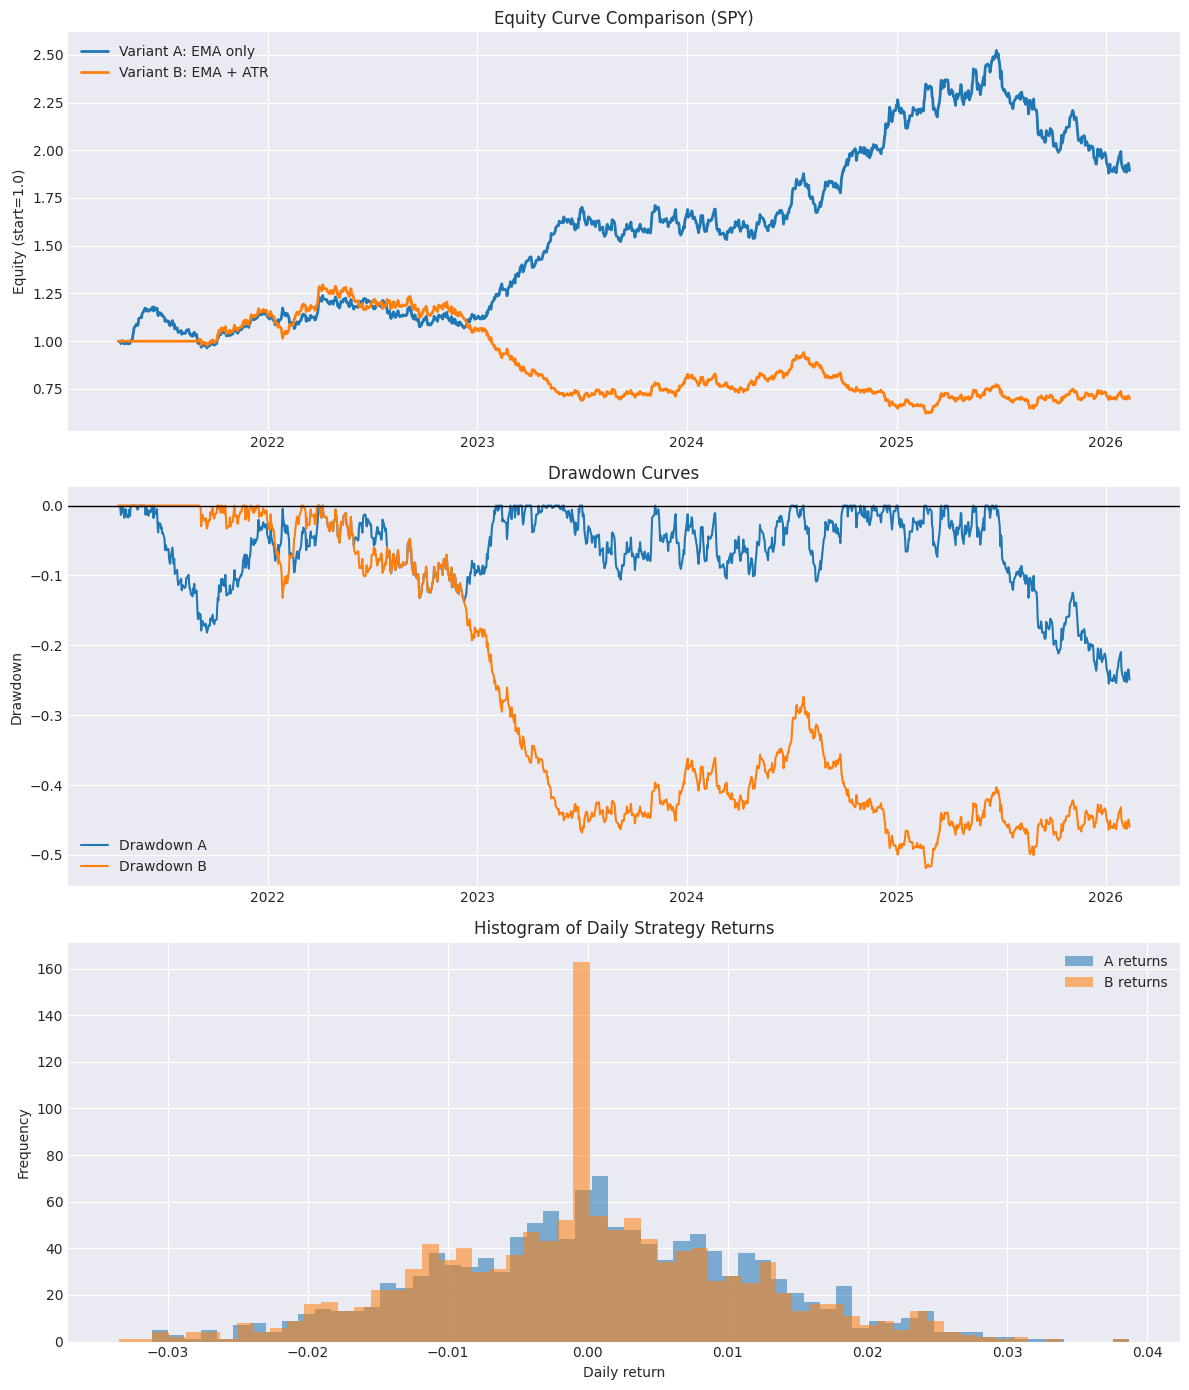

In [6]:
# Drawdown series for plotting.
bt["dd_A"] = bt["equity_A"] / bt["equity_A"].cummax() - 1
bt["dd_B"] = bt["equity_B"] / bt["equity_B"].cummax() - 1

fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)

# (1) Equity
axes[0].plot(bt.index, bt["equity_A"], label="Variant A: EMA only", linewidth=2)
axes[0].plot(bt.index, bt["equity_B"], label="Variant B: EMA + ATR", linewidth=2)
axes[0].set_title(f"Equity Curve Comparison ({SYMBOL})")
axes[0].set_ylabel("Equity (start=1.0)")
axes[0].legend()

# (2) Drawdown
axes[1].plot(bt.index, bt["dd_A"], label="Drawdown A", linewidth=1.5)
axes[1].plot(bt.index, bt["dd_B"], label="Drawdown B", linewidth=1.5)
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Drawdown Curves")
axes[1].set_ylabel("Drawdown")
axes[1].legend()

# (3) Histogram
a_bins = bt["strat_ret_A"].dropna()
b_bins = bt["strat_ret_B"].dropna()
axes[2].hist(a_bins, bins=60, alpha=0.55, label="A returns")
axes[2].hist(b_bins, bins=60, alpha=0.55, label="B returns")
axes[2].set_title("Histogram of Daily Strategy Returns")
axes[2].set_xlabel("Daily return")
axes[2].set_ylabel("Frequency")
axes[2].legend()

plt.tight_layout()
plt.show()


## 7) What to observe (checklist)

- Does Variant B (ATR filter) reduce whipsaw trades compared with Variant A?
- How do total return and max drawdown trade off between A and B?
- Is turnover clearly lower or higher under the active filter?
- Are return distributions fat-tailed or skewed? (histogram shape)
- Is performance concentrated in a few periods (equity jumps), or stable over time?

## 8) Mini exercise

Try these experiments and rerun end-to-end:

1. Increase trend smoothness: `EMA_FAST=20`, `EMA_SLOW=50`
2. Make regime stricter: `ATR_REGIME_WINDOW=90`
3. Make ATR reactive: `ATR_N=7`

For each, compare:
- `annualized_return`
- `max_drawdown`
- `turnover_changes`

Then decide which parameter set better fits your objective (return-seeking vs drawdown control).